# Gymnasium

In [1]:
!pip install gymnasium
!pip install pygame

   ---------------------------------------- 0.0/958.1 kB ? eta -:--:--
   --------------------------------------- 958.1/958.1 kB 14.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ----------------------------- ---------- 7.9/10.6 MB 40.7 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 39.1 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display

In [4]:
env = gym.make("CartPole-v1", render_mode="human")

In [6]:
ob, info = env.reset()
ob, info

(array([-0.04464839,  0.04066925, -0.02920656, -0.03607449], dtype=float32),
 {})

In [7]:
env.render()

In [8]:
env.close()

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [10]:
ob, info = env.reset()
ob, info

(array([ 0.02073547, -0.03369495,  0.01192811,  0.04536859], dtype=float32),
 {})

In [11]:
image = env.render()
image.shape

(400, 600, 3)

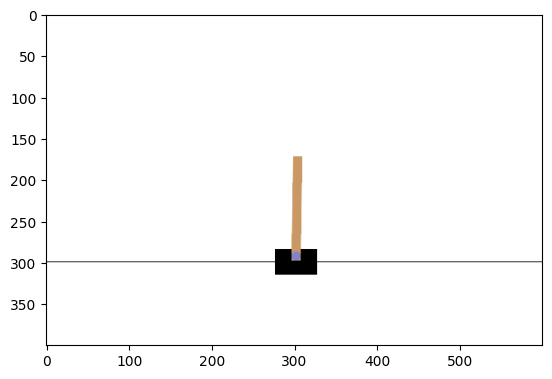

In [12]:
plt.imshow(image)
plt.show()

In [13]:
ob, info = env.reset()
ob, info

(array([-0.02041732,  0.01765045, -0.04148811,  0.04608626], dtype=float32),
 {})

In [14]:
ob, r, done, oob, info = env.step(0)
ob, r, done, oob, info

(array([-0.02006431, -0.17685279, -0.04056639,  0.32539606], dtype=float32),
 1.0,
 False,
 False,
 {})

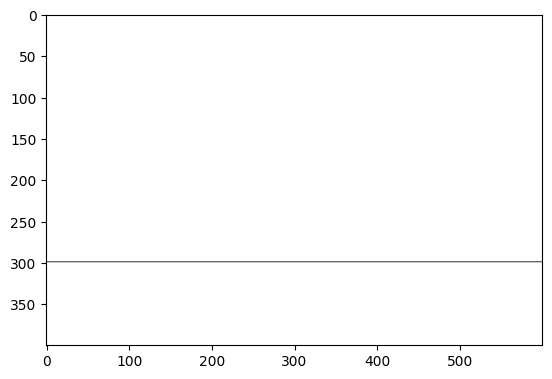

In [20]:
image = env.render()
plt.imshow(image)
plt.show()

[-230.86551   -14.964272  287.8741     18.738422] 0.0 True True {}
[-231.1648    -15.438135  288.2489     18.758575] 0.0 True True {}
[-231.47356   -15.852037  288.62405    18.994715] 0.0 True True {}
[-231.7906    -16.176224  289.00397    19.326986] 0.0 True True {}
[-232.11412   -16.379236  289.3905     19.624796] 0.0 True True {}
[-232.44171   -16.444761  289.783      19.821306] 0.0 True True {}
[-232.77061   -16.385984  290.1794     19.958977] 0.0 True True {}
[-233.09833   -16.24014   290.5786     20.138891] 0.0 True True {}
[-233.42313   -16.053564  290.98138    20.427603] 0.0 True True {}
[-233.7442    -15.877337  291.38992    20.79923 ] 0.0 True True {}


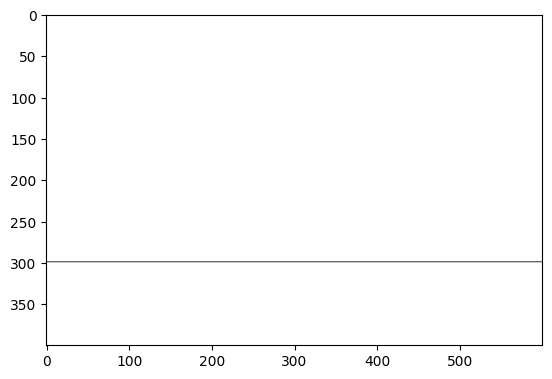

In [28]:
for _ in range(10):
    ob, r, done, oob, info = env.step(0)
    print(ob, r, done, oob, info)

image = env.render()
plt.imshow(image)
plt.show()

In [29]:
env.close()

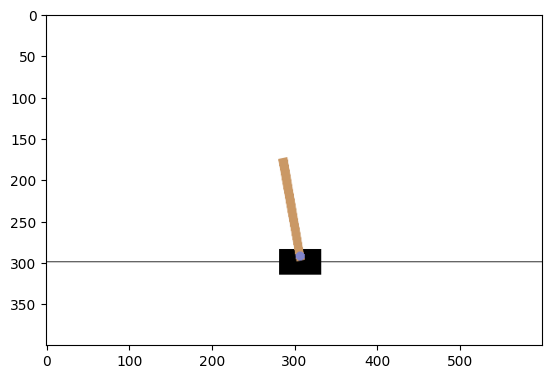

In [31]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset()
img = plt.imshow(env.render())

while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = env.action_space.sample()  # this is where you would insert your policy
    ob, r, done, oob, info = env.step(action)
    
    if done or oob:
        break

env.close()

# DQN

In [33]:
!pip install tqdm

In [34]:
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

import matplotlib.pyplot as plt
from IPython import display

import tqdm

In [90]:
# 학습 파라미터
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 64

In [91]:
# Replay buffer
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(np.array(s_lst), dtype=torch.float), \
               torch.tensor(np.array(a_lst)), \
               torch.tensor(np.array(r_lst)), \
               torch.tensor(np.array(s_prime_lst), dtype=torch.float), \
               torch.tensor(np.array(done_mask_lst))

    def size(self):
        return len(self.buffer)

In [109]:
# Value Based Network
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4,128) # 처음 파라미터 4개 (ob, r, done, oob)
        self.fc2 = nn.Linear(128,128)
        # 상태에 대해서 0,1 액션에 대한 각각의 액션가치 추정
        self.fc3 = nn.Linear(128,2) # 마지막 결과는 2개 (왼쪽 +1, 오른쪽 -1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs):
        out = self.forward(torch.from_numpy(obs).float())
        return out.argmax().item()

In [110]:
class QAgent():
    def __init__(self):
        self.memory = ReplayBuffer() # Replay Buffer
        self.q = Qnet() # Behavior Network
        self.q_target = Qnet() # Target Network

    def sample_action(self, obs, epsilon):
        dice = np.random.random()
        if dice < epsilon: # 일정 확률로 랜덤 탐험
            return np.random.randint(0, 2)
        else: # Q 값이 가장 큰 Action 선택
            return self.q.sample_action(obs)

    def add_history(self, transition):
        self.memory.put(transition)

    def update_behavior(self, optimizer, batch_size, epoch=5):
        for i in range(epoch):
            s, a, r, s_prime, done_mask = self.memory.sample(batch_size)

            q_out = self.q(s) # 상태 s에 대한 q 예측
            q_a = q_out.gather(1, a.long()) # 예측된 q의 액션 a에 대한 추정 q-value
            max_q_prime = self.q_target(s_prime).max(1)[0].reshape(-1,1) # 다음 상태 s'의 q max 값
            # q_target은 학습이 안되도록
            target = r + gamma * max_q_prime.detach() * done_mask # 정답 q-value
            loss = F.mse_loss(q_a, target.float()) # loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def update_target(self):
        self.q_target.load_state_dict(self.q.state_dict())

In [111]:
agent = QAgent()  # Agent
# behavior network의 weight를 target network에 반영
agent.update_target()

In [112]:
# optimizer
optimizer = optim.Adam(agent.q.parameters(), lr=learning_rate)

In [113]:
epsilon = 0.9
score = 0.0
max_score = 0.0
history = []

env = gym.make("CartPole-v1", render_mode="rgb_array")

p_bar = tqdm.trange(5000)
for i in p_bar:
    s, _ = env.reset()

    while True:
        a = agent.sample_action(s, epsilon)
        s_prime, r, done, oob, info = env.step(a)
        done_mask = 0.0 if (done or oob) else 1.0
        agent.add_history ((s, a, r/100.0, s_prime, done_mask))
        s = s_prime
        score += r

        if done or oob:
            break
        
    if agent.memory.size() > 10000:
        agent.update_behavior(optimizer, batch_size)
        # Behavior Network의 Weight를 Target Network에 반영
        agent.update_target()
        # Decay Epsilon
        epsilon = max(0.01, epsilon - 0.001)

        if i % 10 == 9:
            p_bar.set_description(f'max: {max_score:.5f}, curr: {score:5f}')
            if score >= max_score: # 성능 개선이 있었으면
                torch.save(agent.q_target.state_dict(), 'q_target.pth')
                max_score = score
            history.append(score) # Learning History
            score = 0.0
    
    else:
        score = 0.0
    
env.close()


ax: 5000.00000, curr: 2835.000000: 100%|██████████████████████████████████████████| 5000/5000 [01:36<00:00, 51.84it/s]

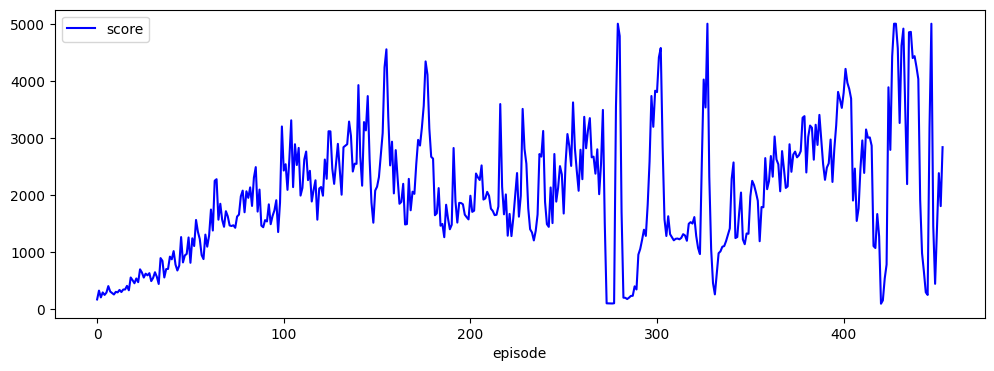

In [114]:
plt.figure(figsize=(12, 4))

plt.plot(history, 'b-', label='score')
plt.xlabel('episode')
plt.legend()
plt.show()

In [116]:
q_target = Qnet()
q_target.load_state_dict(torch.load('q_target.pth'))

<All keys matched successfully>

500.0


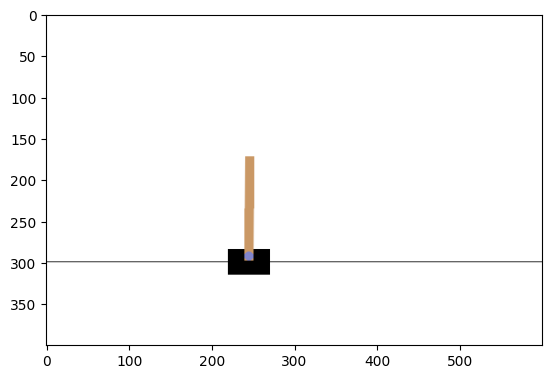

In [118]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
s, _ = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    a = q_target.sample_action(s)
    s_prime, r, done, oob, info = env.step(a)
    s = s_prime
    
    score += r
    if done or oob:
        break

env.close()
print(score)